# Прогнозирование уровня средней заработной платы в России 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from matplotlib import pyplot as plt
import warnings
from itertools import product
from sklearn import metrics
import datetime
from dateutil.relativedelta import relativedelta

C:\Users\d.v.kulemin.UTMN\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
%matplotlib inline

In [3]:
salary = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [4]:
salary.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


## 1. Визуальный анализ ряда

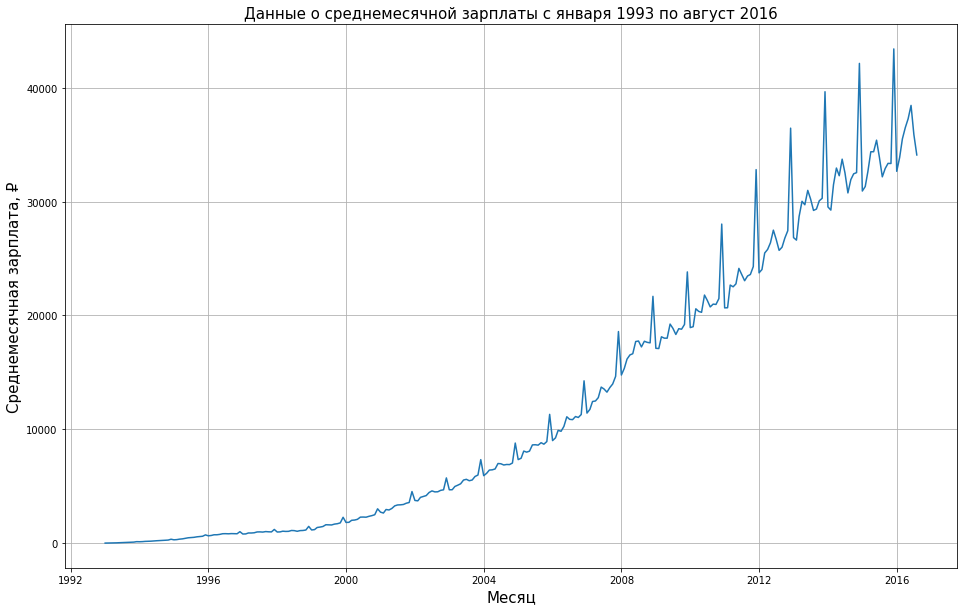

In [5]:
plt.figure(figsize=(16, 10))
plt.plot(salary.WAG_C_M)
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Среднемесячная зарплата, ₽', fontsize=15)
plt.title('Данные о среднемесячной зарплаты с января 1993 по август 2016', fontsize=15)
plt.grid()
plt.show()

* Хорошо виден повышающийся Тренд
* Есть ярко выраженная сезонность с пиками в декабре и самыми низкими зарплатами в январе (сезон равен 12 в соответствии с количеством месяцев в году)
* Видно, что более поздние наблюдения обладают большей дисперсионностью

Построим линейную регрессию just for fun

In [6]:
from sklearn import linear_model

In [7]:
lin_reg = linear_model.LinearRegression()

In [8]:
lin_reg.fit(salary.index.map(datetime.datetime.toordinal).values.reshape(-1, 1), salary.WAG_C_M)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
predicts1 = lin_reg.intercept_ + salary.index.map(datetime.datetime.toordinal).values * lin_reg.coef_

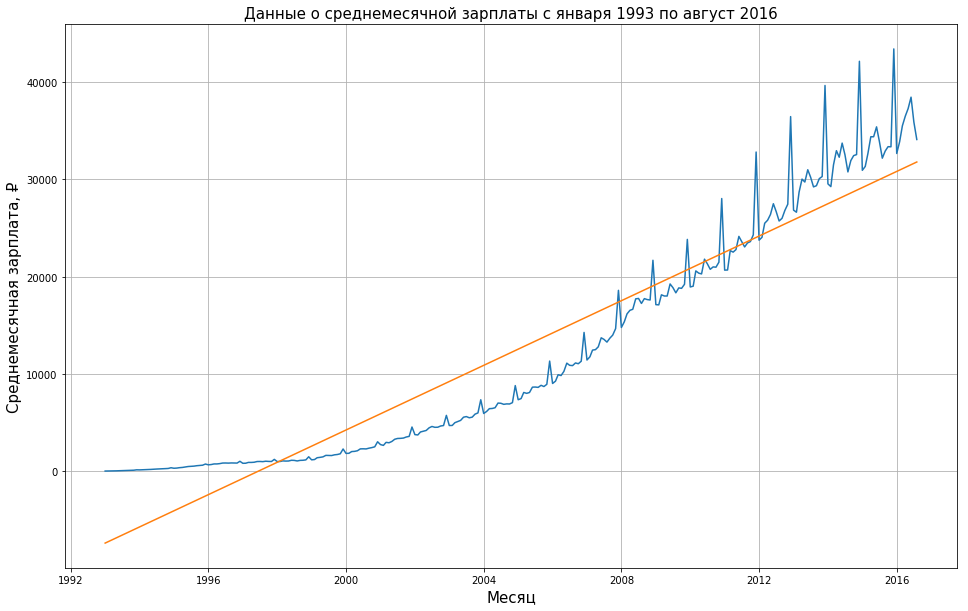

In [10]:
plt.figure(figsize=(16, 10))
plt.plot(salary.WAG_C_M)
plt.plot(salary.index, predicts1)
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Среднемесячная зарплата, ₽', fontsize=15)
plt.title('Данные о среднемесячной зарплаты с января 1993 по август 2016', fontsize=15)
plt.grid()
plt.show()

Смотрим сколько структуры осталось:

In [11]:
eps = salary.WAG_C_M - predicts1

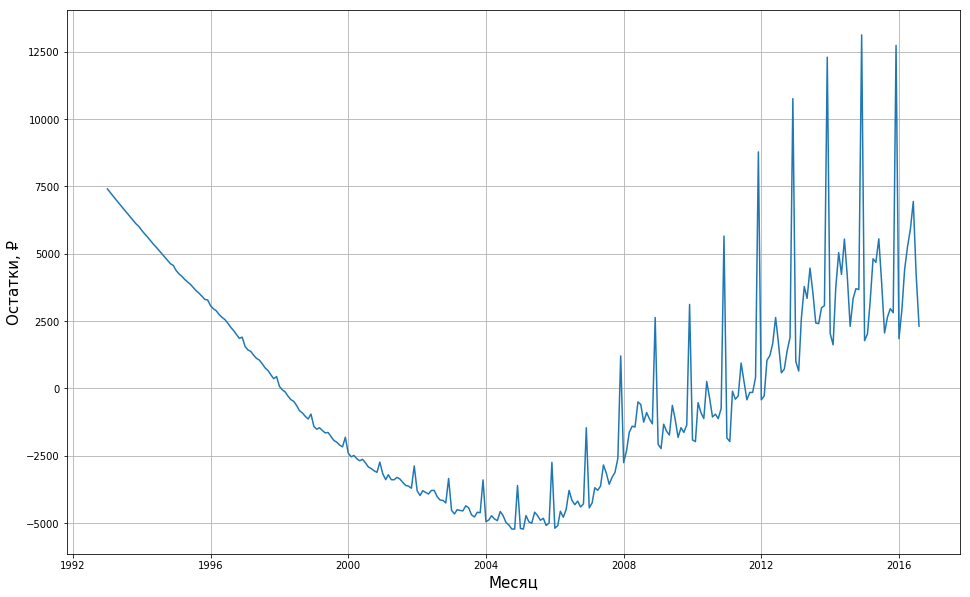

In [12]:
plt.figure(figsize=(16, 10))
plt.grid()
plt.plot(eps)
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Остатки, ₽', fontsize=15)
plt.show()

Добавим еще квадрат признака времени

In [13]:
data = pd.DataFrame.from_records(np.hstack((salary.index.map(datetime.datetime.toordinal).values.reshape(-1, 1), 
                                            salary.index.map(datetime.datetime.toordinal).values.reshape(-1, 1)**2)))
data.columns = ['date', 'date_sqr']

In [14]:
data.head()

,date,date_sqr
0,727564,529349374096
1,727595,529394484025
2,727623,529435230129
3,727654,529480343716
4,727684,529524003856


In [15]:
lin_reg2 = linear_model.LinearRegression()

In [16]:
lin_reg2.fit(data, salary.WAG_C_M)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
predicts2 = lin_reg2.intercept_ + data.date.values * lin_reg2.coef_[0] + data.date_sqr.values * lin_reg2.coef_[1]

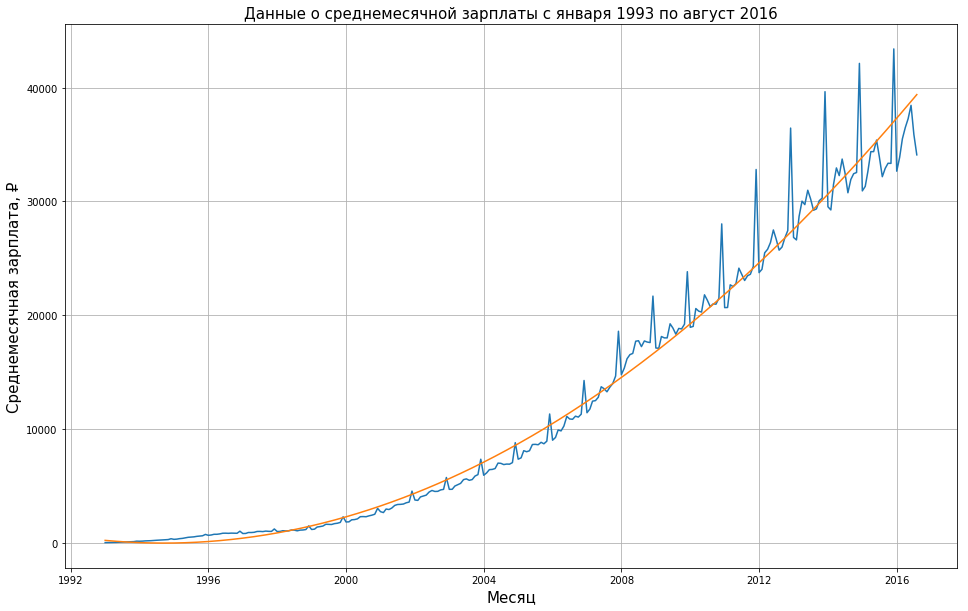

In [18]:
plt.figure(figsize=(16, 10))
plt.plot(salary.WAG_C_M)
plt.plot(salary.index, predicts2)
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Среднемесячная зарплата, ₽', fontsize=15)
plt.title('Данные о среднемесячной зарплаты с января 1993 по август 2016', fontsize=15)
plt.grid()
plt.show()

Смотрим сколько структуры осталось:

In [19]:
eps = salary.WAG_C_M - predicts2

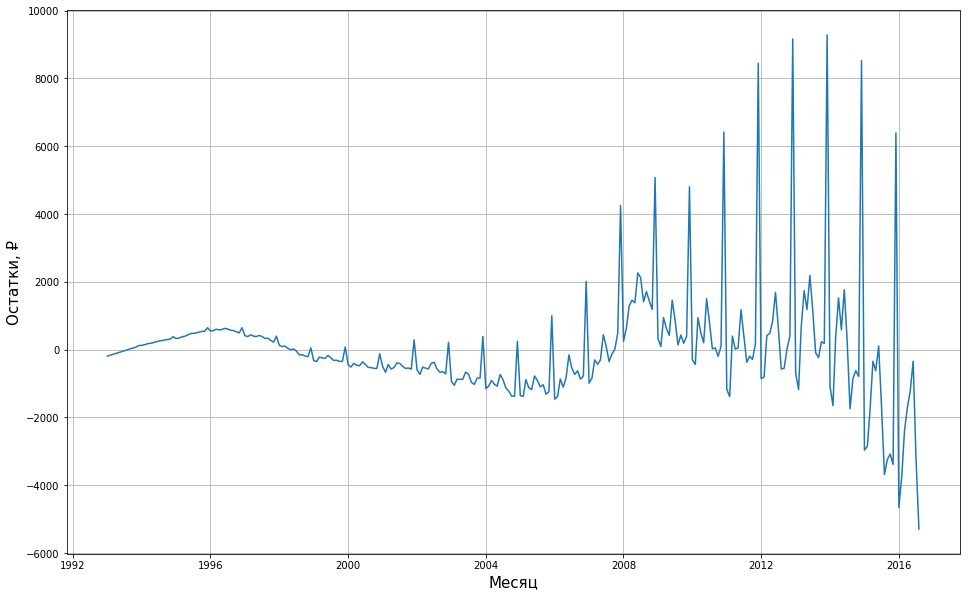

In [20]:
plt.figure(figsize=(16, 10))
plt.grid()
plt.plot(eps)
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Остатки, ₽', fontsize=15)
plt.show()

Вывод: простая линейная регрессия и линейная регрессия с квадратичным признаком плохо описывают данные.

Видно что ряд не стационарен, но все же проверим это формально с помощью критерия Дики-Фуллера и построим STL-декомпозицию ряда.

In [21]:
def stl_plotting(data):
    fig, axes = plt.subplots(4, 1, figsize=(16, 16))
    res = sm.tsa.seasonal_decompose(data)
    for ax, label, fnc in zip(axes, 
                              ['Observed', 'Trend', 'Seasonal', 'Residuals'], 
                              [res.observed.plot, res.trend.plot, res.seasonal.plot, res.resid.plot]):
        fnc(ax=ax)
        ax.grid()
        ax.set_ylabel(label, fontsize=12)

Критерий Дики-Фуллера: p=0.991850


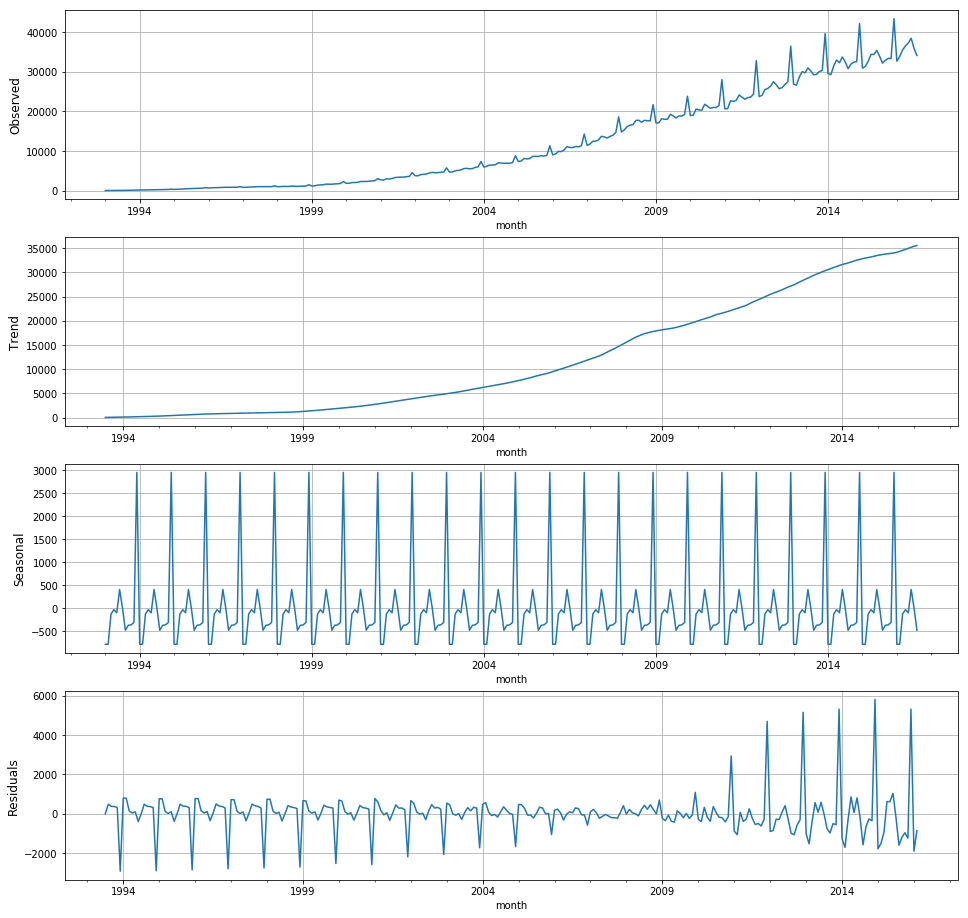

In [22]:
stl_plotting(salary.WAG_C_M)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M)[1])

Гипотеза не стационарности не отвергается, очень хорошо виден тренд.

## 2. Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


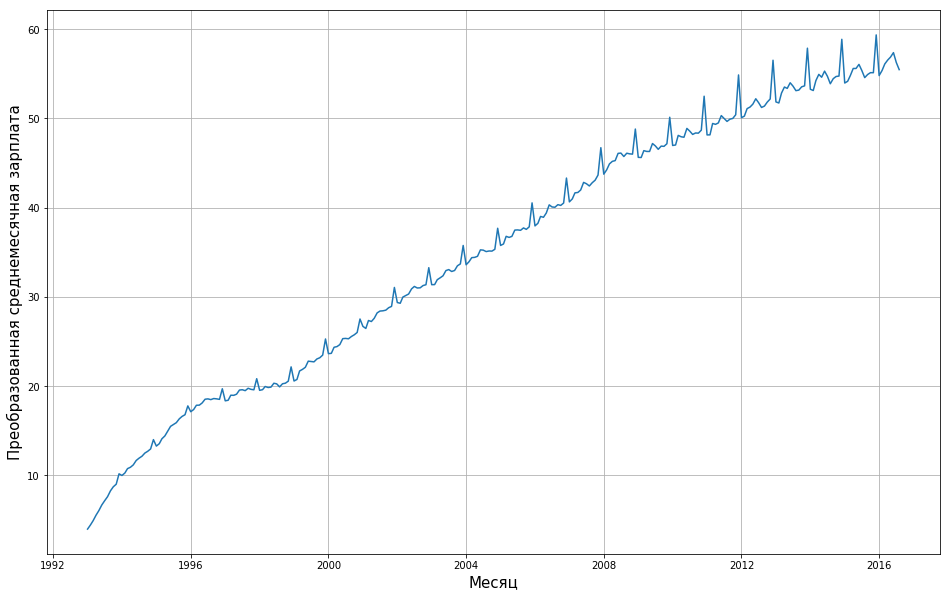

In [23]:
salary['WAG_C_M_box'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize=(16, 10))
plt.plot(salary.WAG_C_M_box)
plt.grid()
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Преобразованная среднемесячная зарплата', fontsize=15)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_box)[1])

Дисперсия стала более стабильной после преобразования.

## 3. Выбор порядка дифференцирования

Чтобы сделать временной ряд стационарным попробуем сначала дифференцировать его на сезонность:

Критерий Дики-Фуллера: p=0.014697


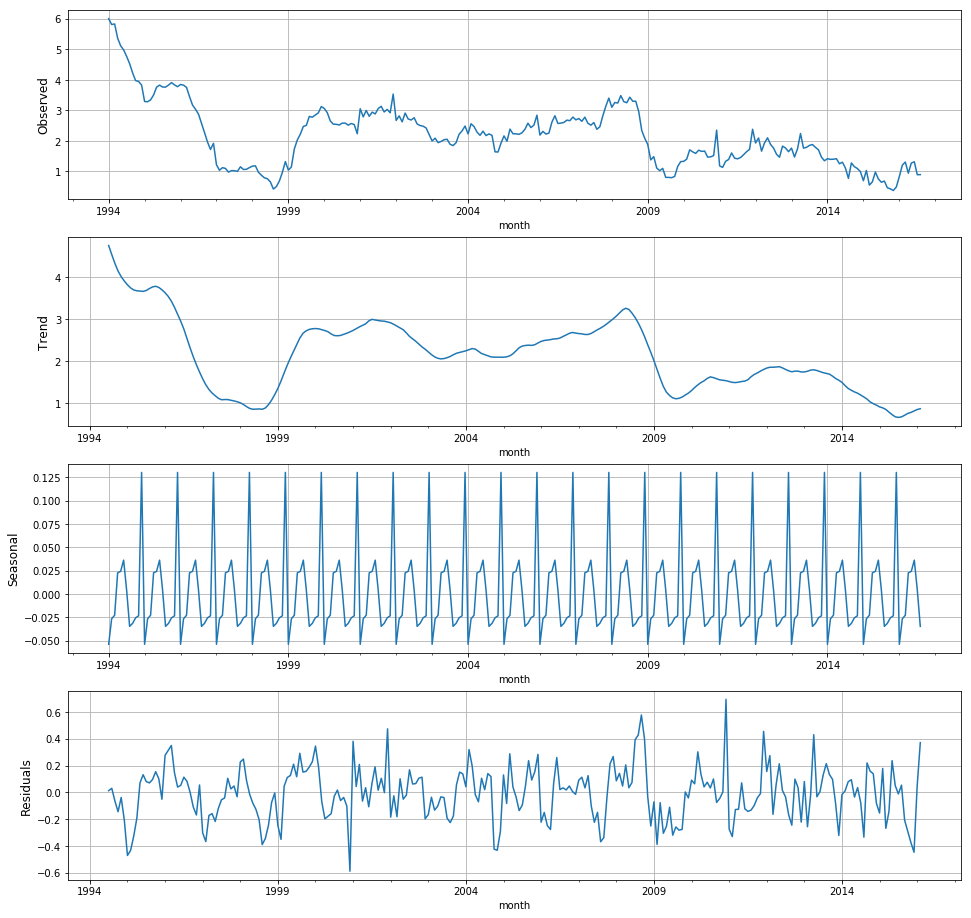

In [24]:
salary['WAG_C_M_box_diff12'] = salary.WAG_C_M_box - salary.WAG_C_M_box.shift(12)
diff12 = salary[salary.WAG_C_M_box_diff12.notnull()].WAG_C_M_box_diff12
stl_plotting(diff12)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(diff12)[1])

Видим, что критерий Дики-Фуллера отвергает нулевую гипотезу нестационарности и остатки колеблются около нуля. Хотя еще присутствует тренд, который теперь понижается.

Для теста сделаем еще одно простое дифференцирование:

Критерий Дики-Фуллера: p=0.000000


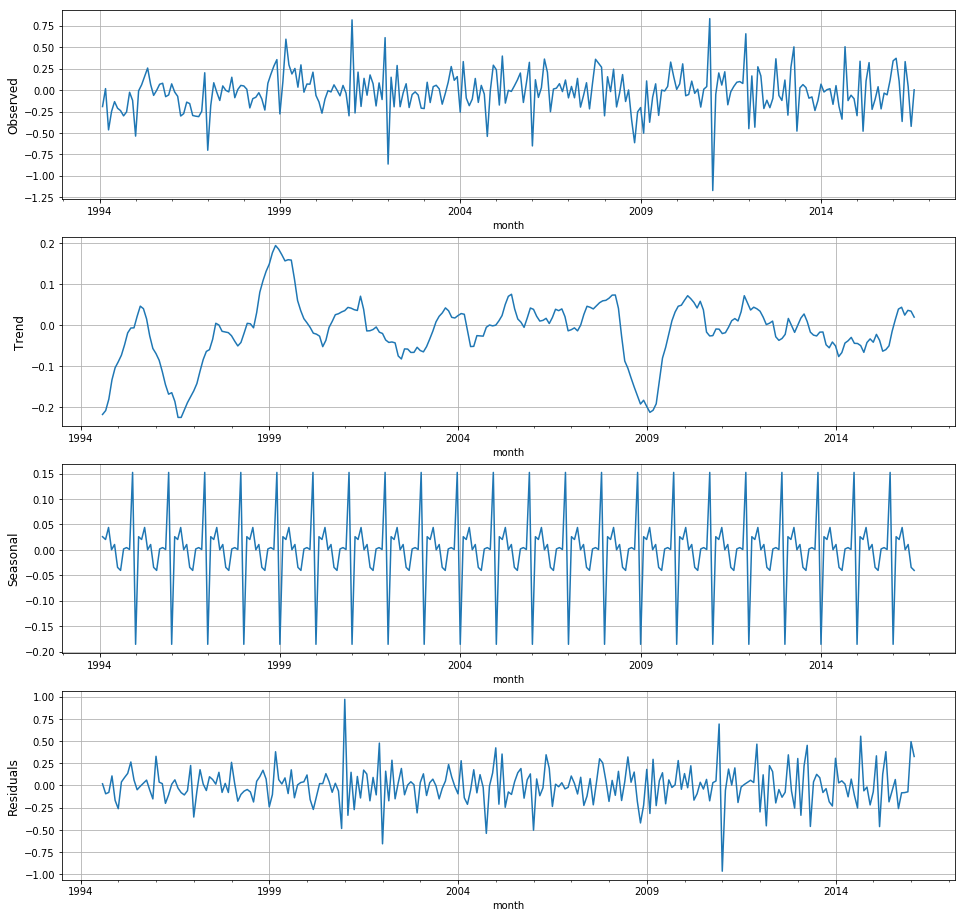

In [25]:
salary['WAG_C_M_box_diff12_1'] = salary.WAG_C_M_box_diff12 - salary.WAG_C_M_box_diff12.shift(1)
diff12_1 = salary[salary.WAG_C_M_box_diff12_1.notnull()].WAG_C_M_box_diff12_1
stl_plotting(diff12_1)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(diff12_1)[1])

Видим что тренда больше нет, гипотеза не стационарности отвергается и ряд визуально выглядит лучше.

## 4. Выбор начальных приближений для p,q,P,Q

Посмотрим на ACF и PACF полученного ряда:

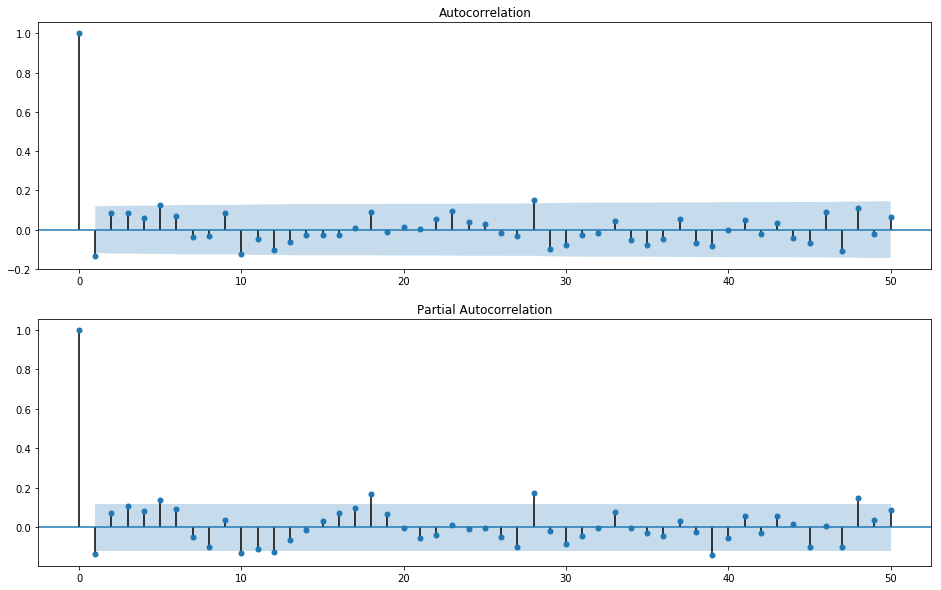

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
sm.graphics.tsa.plot_acf(diff12_1.values.squeeze(), lags=50, ax=axes[0])
sm.graphics.tsa.plot_pacf(diff12_1.values.squeeze(), lags=50, ax=axes[1])
plt.show()

Начальные приближения: Q=0, q=10, P=4, p=1

In [27]:
ps = range(0, 2)
d = 1
qs = range(0, 11)
Ps = range(0, 5)
D = 1
Qs = range(0, 1)

## 5. Обучение и сравнение моделей-кандидатов, выбор победителя

(Код в наглую скопирован из примера :-))

In [28]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

110

In [29]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (1, 2, 2, 0)
wrong parameters: (1, 2, 3, 0)
wrong parameters: (1, 2, 4, 0)
Wall time: 4min 11s


C:\Users\d.v.kulemin.UTMN\AppData\Local\Programs\Python\Python37-32\lib\site-packages\IPython\utils\timing.py:69: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  return time.clock(),0.0


In [30]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

        parameters        aic
100  (1, 10, 0, 0) -16.018469
76    (1, 5, 1, 0) -15.867144
101  (1, 10, 1, 0) -14.976474
77    (1, 5, 2, 0) -14.851644
46    (0, 9, 1, 0) -14.799665


Лучшая модель:

In [31]:
print(best_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:                         WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 10)x(0, 1, 0, 12)   Log Likelihood                  20.009
Date:                             Mon, 29 Jul 2019   AIC                            -16.018
Time:                                     13:58:52   BIC                             27.207
Sample:                                 01-01-1993   HQIC                             1.337
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7663      0.171      4.471      0.000       0.430       1.102
ma.L1         -0.9984      

## 6. Анализ остатков построенной модели

Критерий Стьюдента: p=0.156010
Критерий Дики-Фуллера: p=0.000000


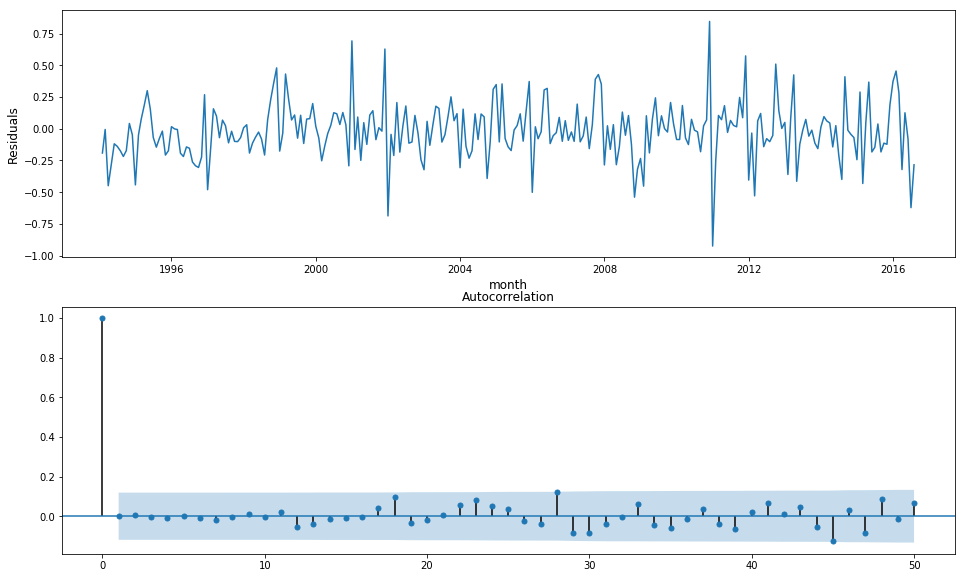

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
axes[0].plot(best_model.resid[13:])
axes[0].set_xlabel('month', fontsize=12)
axes[0].set_ylabel('Residuals', fontsize=12)

sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=50, ax=axes[1])

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента), стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

Посмотрим, насколько хорошо модель описывает данные:

In [33]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

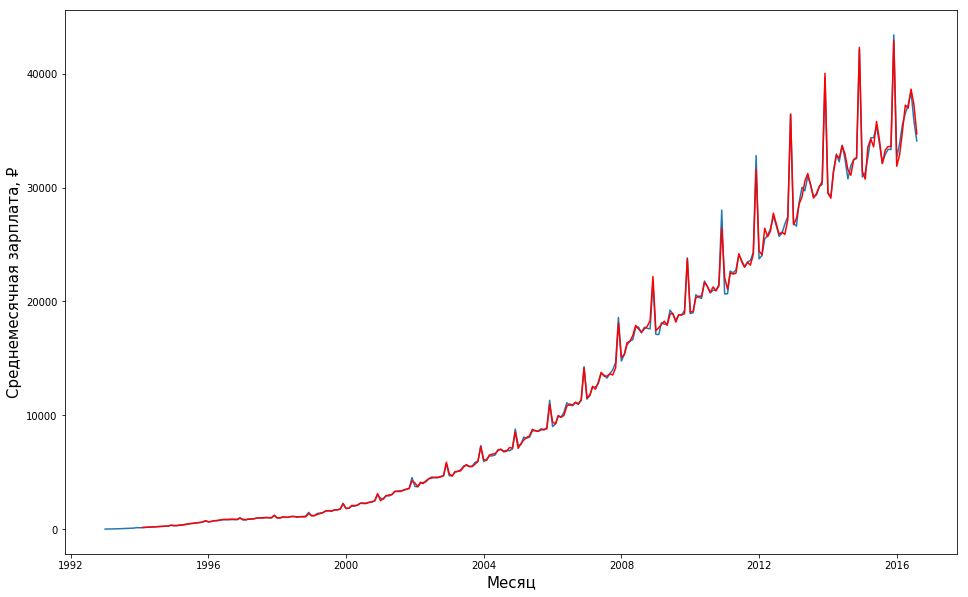

In [34]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(16, 10))
plt.plot(salary.WAG_C_M)
plt.plot(salary.model[13:], color='r')
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Среднемесячная зарплата, ₽', fontsize=15)
plt.show()

In [35]:
eps = salary.WAG_C_M[13:] - salary.model[13:]

Модель отклоняется на 12.29 ₽
Среднеквадратичная ошибка 93633.67


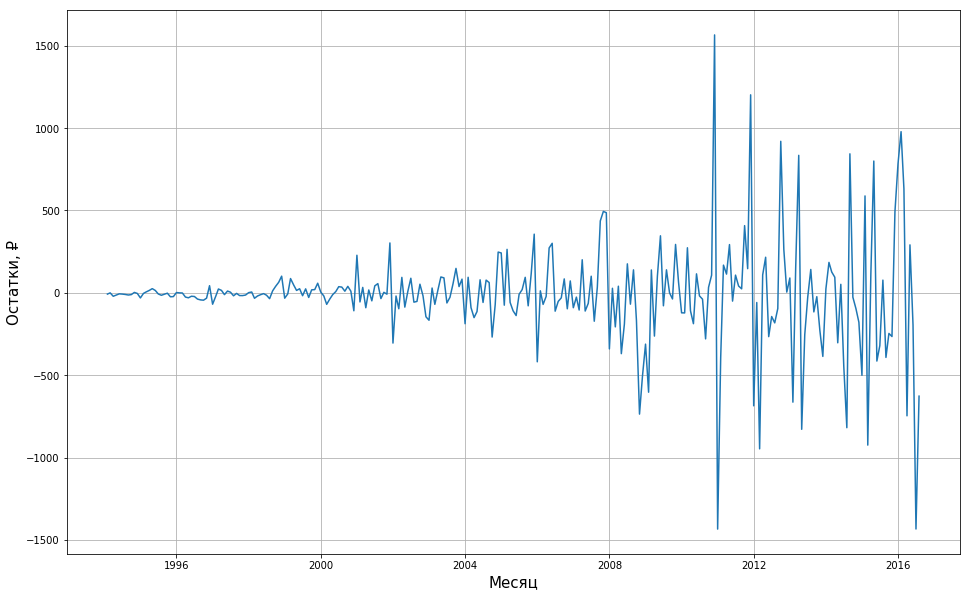

In [36]:
plt.figure(figsize=(16, 10))
plt.grid()
plt.plot(eps)
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Остатки, ₽', fontsize=15)

mser = metrics.mean_squared_error(salary.WAG_C_M[13:], salary.model[13:])

print("Модель отклоняется на %.2f ₽" % np.abs(eps.mean()))
print("Среднеквадратичная ошибка %.2f" % mser)

plt.show()

## 7. Прогнозирование с помощью финальной модели.

In [37]:
import datetime
from dateutil.relativedelta import relativedelta

Ради интереса загрузим реальные данные за следующие два года, и посмотрим насколько хорошо наша модель предсказывает будущее.

In [38]:
add_salary = pd.read_csv('additive_wag.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)

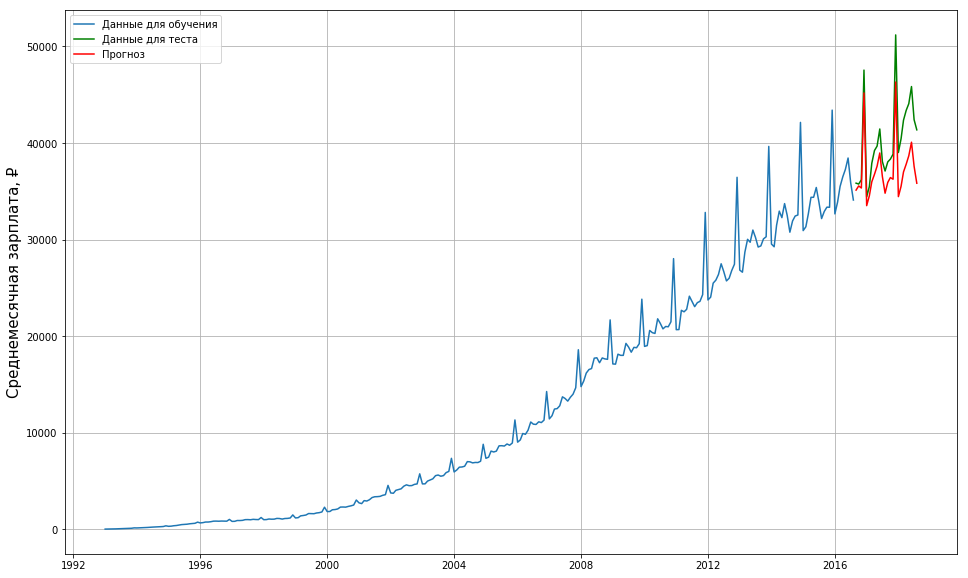

In [39]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0, 25)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

plt.figure(figsize=(16, 10))
plt.grid()
plt.plot(salary2.WAG_C_M, label='Данные для обучения')
plt.plot(add_salary, color='g', label='Данные для теста')
plt.plot(salary2.forecast, color='r', label='Прогноз')
plt.ylabel('Среднемесячная зарплата, ₽', fontsize=15)
plt.legend()
plt.show()

In [40]:
eps = add_salary.WAG_C_M - salary2.forecast[-24:]

Прогноз в среднем отклоняется на 3009.95 ₽
Среднеквадратичная ошибка 12348127.23


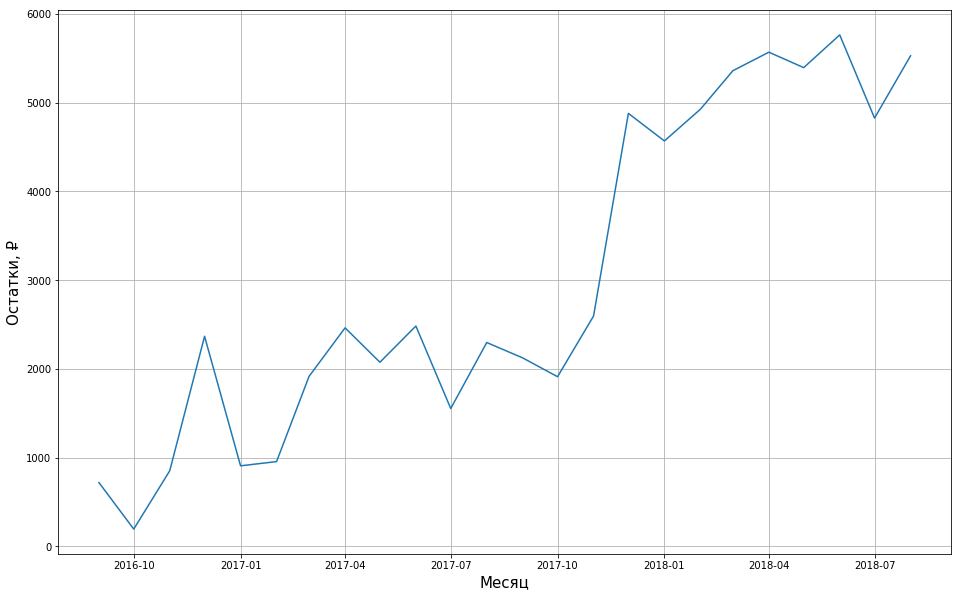

In [41]:
plt.figure(figsize=(16, 10))
plt.grid()
plt.plot(eps)
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Остатки, ₽', fontsize=15)

mser = metrics.mean_squared_error(add_salary.WAG_C_M, salary2.forecast[-24:])

print("Прогноз в среднем отклоняется на %.2f ₽" % np.abs(eps.mean()))
print("Среднеквадратичная ошибка %.2f" % mser)

plt.show()